## Imports

In [10]:
# !pip install numpy==1.26.4

In [11]:
import pandas as pd
import matplotlib.pyplot as plt


In [12]:
# from google.colab import files

# uploaded = files.upload()  # Prompts you to upload files interactively

## Step 1.1: Load SAMSum Dataset and Explore Its Structure

In [13]:
# Load the CSVs
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("validation.csv")
test_df = pd.read_csv("test.csv")
print(train_df.head())

         id                                           dialogue  \
0  13818513  Amanda: I baked  cookies. Do you want some?\nJ...   
1  13728867  Olivia: Who are you voting for in this electio...   
2  13681000  Tim: Hi, what's up?\nKim: Bad mood tbh, I was ...   
3  13730747  Edward: Rachel, I think I'm in ove with Bella....   
4  13728094  Sam: hey  overheard rick say something\nSam: i...   

                                             summary  
0  Amanda baked cookies and will bring Jerry some...  
1  Olivia and Olivier are voting for liberals in ...  
2  Kim may try the pomodoro technique recommended...  
3  Edward thinks he is in love with Bella. Rachel...  
4  Sam is confused, because he overheard Rick com...  


In [14]:
# Clean train set
train_df = train_df.dropna(subset=["dialogue", "summary"]).copy()
train_df = train_df[train_df["dialogue"].apply(lambda x: isinstance(x, str) and x.strip() != "")]
train_df = train_df[train_df["summary"].apply(lambda x: isinstance(x, str) and x.strip() != "")]
train_df = train_df.reset_index(drop=True)

# Repeat for val and test
val_df = val_df.dropna(subset=["dialogue", "summary"]).copy()
val_df = val_df[val_df["dialogue"].apply(lambda x: isinstance(x, str) and x.strip() != "")]
val_df = val_df[val_df["summary"].apply(lambda x: isinstance(x, str) and x.strip() != "")]
val_df = val_df.reset_index(drop=True)

test_df = test_df.dropna(subset=["dialogue", "summary"]).copy()
test_df = test_df[test_df["dialogue"].apply(lambda x: isinstance(x, str) and x.strip() != "")]
test_df = test_df[test_df["summary"].apply(lambda x: isinstance(x, str) and x.strip() != "")]
test_df = test_df.reset_index(drop=True)


These lines clean the DFS by removing rows where either dialogue or summary is missing or empty, then reset the index for convenience. This helps ensure the model trains on valid, meaningful data.

In [15]:
# !pip install datasets

In [16]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
#examine shapes of each

(14731, 3)
(818, 3)
(819, 3)


## Step 1.2 Analyze Characteristics and Dialogue Summaries

In [17]:
# Add length columns
train_df['dialogue_len'] = train_df['dialogue'].apply(lambda x: len(str(x).split()))
train_df['summary_len'] = train_df['summary'].apply(lambda x: len(str(x).split()))

To better understand the dataset, calculate and store the number of words in each dialogue and summary. This helps inform tokenization limits and model configuration.

In [18]:
print("\nDialogue Lengths:")
print(train_df['dialogue_len'].describe())

print("\nSummary Lengths:")
print(train_df['summary_len'].describe())
#get summary statistics


Dialogue Lengths:
count    14731.000000
mean        93.792750
std         74.031937
min          7.000000
25%         39.000000
50%         73.000000
75%        128.000000
max        803.000000
Name: dialogue_len, dtype: float64

Summary Lengths:
count    14731.000000
mean        20.318444
std         11.153570
min          1.000000
25%         12.000000
50%         18.000000
75%         27.000000
max         64.000000
Name: summary_len, dtype: float64


In [19]:
#Check for null values
print("Nulls in train set:")
print(train_df.isnull().sum())

Nulls in train set:
id              0
dialogue        0
summary         0
dialogue_len    0
summary_len     0
dtype: int64


In [20]:
train_df = train_df.dropna(subset=["dialogue"]).reset_index(drop=True) #drop the 1 null

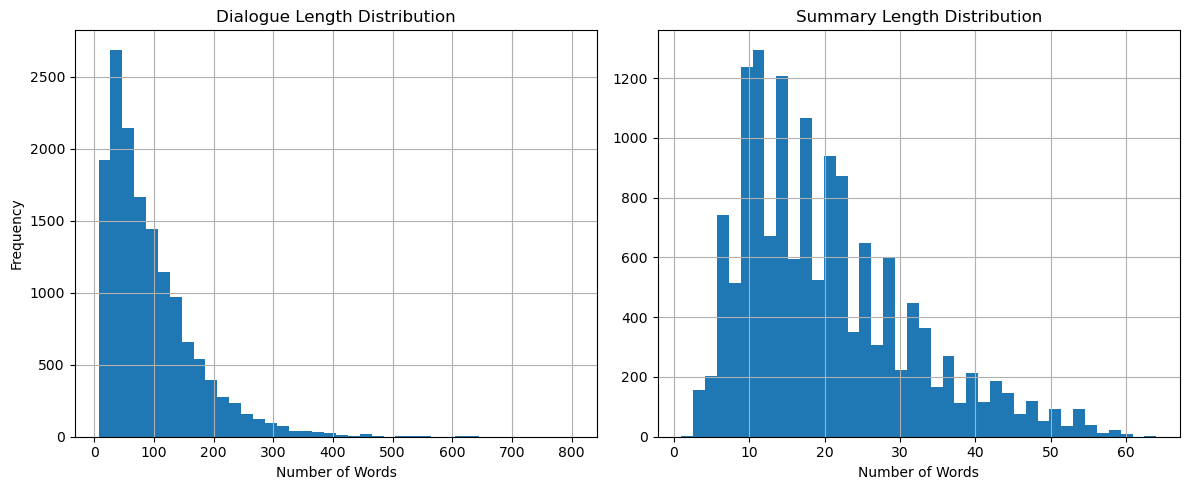

In [21]:
#visuzlize the distriburions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train_df['dialogue_len'].hist(bins=40)
plt.title('Dialogue Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
train_df['summary_len'].hist(bins=40)
plt.title('Summary Length Distribution')
plt.xlabel('Number of Words')

plt.tight_layout()
plt.show()

## Step 1.3 Prepare the Data for Input to the BERT Model

In [22]:
# Step 1: Clean DataFrames
train_df = train_df.dropna(subset=["dialogue", "summary"]).reset_index(drop=True)
val_df = val_df.dropna(subset=["dialogue", "summary"]).reset_index(drop=True)
test_df = test_df.dropna(subset=["dialogue", "summary"]).reset_index(drop=True)

# Step 2: Convert to Hugging Face Dataset
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df[["dialogue", "summary"]])
val_dataset = Dataset.from_pandas(val_df[["dialogue", "summary"]])
test_dataset = Dataset.from_pandas(test_df[["dialogue", "summary"]])


The SAMSum dataset already came split. I have a test.csv, train.csv, and validation.csv

The cleaned train, validation, and test DataFrames are converted into Hugging Face dataset objects. This enables streamlined integration with tokenizers and training pipelines. A necessary step in this process.

In [23]:
#Implement appropriate tokenization
from transformers import BartTokenizer, BartForConditionalGeneration

# Load pretrained BART tokenizer and model

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

model.config.decoder_start_token_id = tokenizer.cls_token_id

# Define tokenization function to tokenize both dialogue (inputs) and summary (labels)

def tokenize_function(examples):
    inputs = tokenizer(examples["dialogue"],
                       max_length=128, truncation=True, padding="longest")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"],
                           max_length=128, truncation=True, padding="longest")
    pad = tokenizer.pad_token_id
    labels["input_ids"] = [
        [(tok if tok != pad else -100) for tok in seq] for seq in labels["input_ids"] # Replace padding token in labels with -100 to ignore them during loss calculation
    ]
    inputs["labels"] = labels["input_ids"]
    return inputs


This step loads the pretrained facebook/bart-base tokenizer and model, then defines a tokenization function. 
- The function tokenizes both the dialogue (input) and summary (target).
- Padding is applied to the longest sequence.
- Padding tokens in the target are replaced with -100 so that the loss function ignores them during training.

I spent a lot of time trying to get BERT to work. As soon as I switched over to BART, I had instantly differnet success.

Padding:
When training models like BART, all sequences in a batch must be the same length. Since dialogues and summaries vary in length, we pad shorter sequences with a special token ([PAD]) to match the longest one in the batch.

For the inputs, this is handled automatically by the attention mask, which tells the model to ignore padded tokens during encoding.

For the labels (summaries), we must manually replace [PAD] tokens with -100 so that the loss function ignores them during training. If this step is skipped, the model will try to predict [PAD] tokens, inflating accuracy and misleading you with artificially low training loss.

Early in my project, I saw unusually strong training scores — this was because I hadn’t properly masked out padding in the labels, and the model was being rewarded for predicting meaningless [PAD] tokens.


In [24]:
model.config.pad_token_id = tokenizer.pad_token_id #this sets the model's padding token ID to match the tokenizer's [PAD] token.
# model.config.vocab_size = model.config.encoder.vocab_size #line removed when swithced to BART because BART knows its Vocab size

#apply the tokenize function to each dataset
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

/opt/anaconda3/envs/churn-xgb/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Before tokenizing, we configure the model to recognize the [PAD] token used during preprocessing. This ensures that padding tokens are properly ignored during loss computation.

pad_token_id is explicitly set to match the tokenizer's pad token.

The vocab_size line is commented out because BART's pretrained config already sets it correctly.

We then apply the  tokenize_function to the train, validation, and test datasets using .map() with batching enabled. This function tokenizes both dialogues and summaries, pads them to uniform length, and replaces padding in labels with -100 (ignore if [PAD] is output) so they are ignored during loss calculation.

In [25]:
tokenized_train = tokenized_train.filter(lambda x: len(x["input_ids"]) > 0) #from gpt to proceed

Filter:   0%|          | 0/14731 [00:00<?, ? examples/s]

Remove any samples from the training set where the input_ids list is empty. This prevents passing invalid or empty sequences to the model during training. LLM suggested adding this line of code. This was implemented early when I had errors with BERT. It did not seem to hurt the performance so I left it in.

In [26]:
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
#formatting for pytorch use

In [27]:
small_train_dataset = tokenized_train.select(range(2000))
small_val_dataset   = tokenized_val.select(range(400))
#creating small dataset for training

Originally ran 100 samples and 50 validation to test loop. It trained locally, but did not have any luck with actual summarization/did not learn anything.

I then changed to 500 samples and 100 validation over 3 epochs. Training took about 4 hours, but the model was unable to summarize. This was done with BERT.

I switched to BART, was able to access GPU and ran 2000 samples with 400 validation. Eventually I did not train on the small datasets and trained on the entire SAMSum dataset.

In [28]:
from torch.utils.data import DataLoader
from transformers import DataCollatorForSeq2Seq
#create a collator that pads dynamically to the longest sequence in each batch
collator = DataCollatorForSeq2Seq(tokenizer, model=model, padding="longest")

#create PyTorch DataLoaders for the small training and validation subsets
train_dataloader = DataLoader(small_train_dataset, batch_size=2, shuffle=True, collate_fn=collator) #collate_fn=collator ensures dynamic padding per batch
val_dataloader = DataLoader(small_val_dataset, batch_size=2, collate_fn=collator)

This code block prepares PyTorch DataLoaders for training and validation. It uses a DataCollatorForSeq2Seq to dynamically pad sequences in each batch to the longest length, ensuring all tensors align properly during training. Again, I encountered this as a trianing issue early on as well. "arrays did not match length".

## Step 2: Model Architecture Implementation

In [ ]:
#model config
#model.config.eos_token_id = tokenizer.sep_token_id remove in BART
model.config.max_length = 128 #max length of summaries
model.config.no_repeat_ngram_size = 3 #no repeats of n-gram size
model.config.early_stopping = True #implement eraly stopping

# Freeze the encoder for speed. Print confirmation that it is frozen. Comment out if not using
for p in model.get_encoder().parameters():
    p.requires_grad_(False)
print("Encoder frozen; only decoder & cross-attention will train.")

Encoder frozen; only decoder & cross-attention will train.


 These parameters don’t affect training directly, but they help improve generation quality during validation or testing by limiting redundancy and unnecessary length.

 Can choose to comment/uncomment the for loop for freezing the encoder. Freezing the encoder skips gradient computation and weight updates for it, reducing training time. It focuses training only on the decoder and cross-attention layers. Adding it back in increases computation time, but could increase performance.

Freezing the encoder helped with speed of the training. This was removed for the final model training.

In [30]:
from torch.optim import AdamW
import torch.nn as nn
import torch

optimizer = AdamW(model.parameters(), lr=3e-5) #bart 3e-5
# loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id) #BART does this

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #help make sure GPU was used
model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): Laye

Used ADAM optimizer and a googled recommended learning rate of 3e-5

In [ ]:
num_epochs = 3 #can change for training purposes

ACCUM = 8                     # effective batch size = 2 × 8 = 16
steps_per_epoch = len(train_dataloader) // ACCUM

#set warmup to i
from transformers import get_linear_schedule_with_warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=max(50, int(0.1 * steps_per_epoch * num_epochs)),
    num_training_steps=steps_per_epoch * num_epochs,)


Jumping straight to a high learning rate at the beginning of training can destabilize the model. Warm-up gradually increases the learning rate from a small value to the target value over a fixed number of steps (in this case, 50+ steps or 10% of total steps).

## Step 3 Training and Optimization

In [32]:
#Loop below. Ran on Google Collab and downloaded locally
# from tqdm import tqdm

# for epoch in range(num_epochs): #repeart for each epoch
#     print(f"\nEpoch {epoch+1}/{num_epochs}")
#     model.train()
#     running_train = 0 #tracks cummulative loss
#     step = 0

#     #train
#     for batch in tqdm(train_dataloader, desc=f"Training"): #tdqm shows progress bar while training 
#         input_ids      = batch["input_ids"].to(device) #to device is gpu
#         attention_mask = batch["attention_mask"].to(device)
#         labels         = batch["labels"].to(device)
##Runs the model forward and computes the loss.
#         outputs = model(input_ids=input_ids, 
#                         attention_mask=attention_mask,
#                         labels=labels)

#         loss = outputs.loss / ACCUM          # scale for accumulation 
#         loss.backward()
#         running_train += loss.item() * ACCUM
#         step += 1

#         # update every ACCUM mini-batches
#         if step % ACCUM == 0:
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#             optimizer.step(); scheduler.step(); optimizer.zero_grad()

#     avg_train = running_train / step
#     print(f"Avg Training Loss: {avg_train:.4f}")

#     #validate
#     model.eval()
#     running_val = 0; v_steps = 0
#     with torch.no_grad():
#         for batch in tqdm(val_dataloader, desc="Validating"):
#             input_ids      = batch["input_ids"].to(device)
#             attention_mask = batch["attention_mask"].to(device)
#             labels         = batch["labels"].to(device)

#             loss = model(input_ids=input_ids,
#                          attention_mask=attention_mask,
#                          labels=labels).loss
#             running_val += loss.item(); v_steps += 1

#     avg_val = running_val / v_steps
#     print(f"Avg Validation Loss: {avg_val:.4f}")




In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration, pipeline

# MODEL_DIR = ("/Users/spencerpolans/Example Folder/Capstone/Project 3/""bart-model/bart-samsum-2000-v1")  #local path for testing. #change to your local path to use model
MODEL_DIR = ("/Users/spencerpolans/Example Folder/Capstone/Project 3/""bart-samsum-full-5") 
tok   = BartTokenizer.from_pretrained(MODEL_DIR)
model = BartForConditionalGeneration.from_pretrained(MODEL_DIR)

summ = pipeline("summarization", model=model, tokenizer=tok, max_length=60, min_length=10, num_beams=6)

print(summ("Amanda: I baked cookies.\nJerry: Nice!\nAmanda: Pick them up after 3.")[0]["summary_text"])


/opt/anaconda3/envs/churn-xgb/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:554: UserWarning: `num_beams` is set to None - defaulting to 1.
  warnings.warn("`num_beams` is set to None - defaulting to 1.", UserWarning)
Your max_length is set to 60, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Amanda baked cookies. Jerry will pick them up after 3.


In [ ]:
# Pick a single dialogue from the validation or test DataFrame
sample_row = val_df.iloc[20]  #can pick any number

dialogue_text = sample_row["dialogue"]
reference_summary = sample_row["summary"]

# Tokenize and generate prediction
inputs = tok(dialogue_text, return_tensors="pt", max_length=128, truncation=True).to(model.device)

with torch.no_grad():
    generated_ids = model.generate(
        **inputs,
        max_length=320,
        min_length=10,
        num_beams=6,
        length_penalty=1.0,
        no_repeat_ngram_size=3,
        early_stopping=True,)

generated_summary = tok.decode(generated_ids[0], skip_special_tokens=True)

# Print
print("DIALOGUE:\n", dialogue_text)
print("\n REFERENCE SUMMARY:\n", reference_summary)
print("\n GENERATED SUMMARY:\n", generated_summary)


DIALOGUE:
 Ramzi: Mom is calling for supper
Jannette: Ok Im coming 
Ramzi: 👍

 REFERENCE SUMMARY:
 Ramzi and Jannette are going for supper.

 GENERATED SUMMARY:
 Ramzi's mom is calling for supper. Jannette is coming.


## Step 4 Evaluation and Analysis

In [36]:
# !pip install rouge_score

In [37]:
# !pip install evaluate

In [ ]:
from datasets import Dataset
import evaluate, torch

#Convert the DataFrame → Dataset  (one line)
val_ds = Dataset.from_pandas(val_df[["dialogue", "summary"]])

#Generate predictions in batches for scoring
def generate(batch):
    inputs = tok(
        batch["dialogue"],
        max_length=128, truncation=True, padding="longest",
        return_tensors="pt"
    ).to(model.device)

    with torch.no_grad(): #can change these parameters to try to improve rouge scores
        gen_ids = model.generate(
            **inputs,
            max_length=64, min_length=10,
            num_beams=4, length_penalty=1.5,
            no_repeat_ngram_size=2, early_stopping=True,
        )
    batch["pred"] = tok.batch_decode(gen_ids, skip_special_tokens=True)
    return batch

pred_ds = val_ds.map(generate, batched=True, batch_size=16)

#Compute ROUGE
rouge = evaluate.load("rouge")
scores = rouge.compute(
    predictions=pred_ds["pred"],
    references=pred_ds["summary"],
    use_stemmer=True,
)
print({k: round(v * 100, 2) for k, v in scores.items()})


Map:   0%|          | 0/818 [00:00<?, ? examples/s]

{'rouge1': 50.49, 'rouge2': 26.32, 'rougeL': 41.78, 'rougeLsum': 41.83}


Initial ROUGE values (bart-model): {'rouge1': 42.39, 'rouge2': 19.31, 'rougeL': 35.21, 'rougeLsum': 35.15}: bart-samsum-2000-v1

Excellent results. Close to being in line with what I would define success as. Per my project pitch: "For ROUGE-1 I will look at >= 0.45, ROUGE-2 >= 0.20, and ROUGE L >= 0.40. A preliminary google search indicated that scores should fall between the range of 0.3-0.5 (but can vary)." 

Training on full set (bart-samsum-full):
{'rouge1': 46.94, 'rouge2': 22.53, 'rougeL': 38.47, 'rougeLsum': 38.5}

Training on the full dataset improved the model! We can see the largest increase in rouge2 by percentage increase (bigrams). I am comfortable with these results! I am going to unfreeze the encoder and train on more epochs to see if there is improvement.

Unfreezing the encoder and training on 5 epochs (bart-samsum-full-5):
{'rouge1': 50.49, 'rouge2': 26.32, 'rougeL': 41.78, 'rougeLsum': 41.83}

Wow! What an improvement! These results exceed what my pitch shot for! Unfreezing the encoder and increasing the sample size has demonstrated significant metric improvement. My model is now producing coherent outputs that, in some cases, I feel does a better job with summarization than the human level summaries. 

## Resource Management

Trying to be cognizant of local resource usage. Full training could take hours. I am doing the following to start:

1) Only working on a small subset of the dataset
2) Using a smaller batch size 
3) Limiting number of epochs (1)
4) Move training in Collab. GPU access

## Additional Thoughts and Reflection

In my first attempt, the model was mostly learning the wrong things. It spent a lot of time focusing on padding tokens, which are just placeholders and don’t carry any real meaning. These padding tokens were also being included in the model’s expected outputs, so it was actually being rewarded for predicting them... which led to incoherent outputs (periods, tokens). On top of that, the encoder (a big part of the model) was still training, which wasn’t helpful because my dataset was so small. I was also training with tiny batches, which made the learning very unstable. The learning rate didn’t adjust over time, so the training started off too fast and then didn’t improve much.

In order to correc this I made several changes. Firstly, I changed the padding. I told the model to ignore padding tokens (setting them as -100). I froze the encoder so the model cold focus on summary generation and set the learning rate. These changes made training faster and helped the model actually learn.

Obviously the biggest factor here is the change from BERT2BERT to a BART based model. BART is a better choice for summarization than BERT because it was designed as a sequence to sequence model which makes it suited for this specific task of generating summaries. BERT, in contrast, is only an encoder which limits the ability to generate coherent outputs(something I saw plenty when testing).







## Business Implications

Given the strength of the initial model (ROUGE score >35), this successfully fulfills the business goal of ACME Communications of summarizing group chats. This should reduce information overload for users, improve engagement by making conversations more accessible, and enhance the platform by utilizing AI. A feasible prototype has been developed as seen by the above summaries generated. Some additional benefits are:
1)	Reduces cognitive load: users no longer would have to go through dozens or hundreds of messages. The idea would be to extract the key points from the conversation which would allow the user to re-engage with the platform even after prolonged inactivity.
2)	Enhanced Value: Theoretically we could generate on-demand summaries (be it daily or weekly). This allows the user to be informed without constantly being online. If you’re on vacation, you can easily catch up once you are back to work. This should greatly improve productivity and communication amongst individuals and professional teams.
3)	Monetization Opportunities: “Premium” tools can be monetized (maybe something like key alerts).
4) In various fields this can used outside of dialogue conversation. Perhaps it can help summarize lengthy documents; helping in faster decision making.
5) Competitve Differentiation: this is not something that is widely used in the industry. This could help differentiate ACME as a unique selling point and drive profits.

By having all of this, a well-performing summarization model can help both internal and external facing features.